In [80]:
import torch
import torchvision
from torch import nn 
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
import numpy as np
from scipy.io import loadmat
from scipy.io import savemat 
import dataset_utils

In [2]:
df = pd.read_csv('final_dataset.csv',index_col=0)
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)
species2genus = dataset_utils.species_label_to_genus_label(df,image_dataset)
batch_size = 1000 
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_val, X_test, y_train_val, y_test = dataset_utils.data_split(nucleotides,0.2,random_state=42)
train_data = X_train_val
train_data['species_name'] = y_train_val
X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)




In [3]:
sorted_keys = sorted(species2genus.keys())
species2genus = np.array([species2genus[key] for key in sorted_keys])
print(species2genus)
species2genus = species2genus[...,np.newaxis]
species2genus.shape

[234 234 235 ...  44  44 311]


(1050, 1)

In [4]:
described_species_labels_train = set(np.array([image_dataset.targets[i] for i in train_indices]))
described_species_labels_trainval = set(np.array([image_dataset.targets[i] for i in train_indices+val_indices]))

In [5]:
train_loc = train_indices
trainval_loc = train_indices+val_indices

n_seen_val = 0
val_all_loc = set()
val_seen_loc = set() 
for i in val_indices:
    val_all_loc.add(i)
    if image_dataset[i][1] in described_species_labels_train:
        n_seen_val+=1
        val_seen_loc.add(i)
val_unseen_loc = val_all_loc - val_seen_loc


n_seen_test = 0
test_all_loc = set()
test_seen_loc = set() 
for i in test_indices:
    test_all_loc.add(i)
    if image_dataset[i][1] in described_species_labels_trainval:
        n_seen_test+=1
        test_seen_loc.add(i)
test_unseen_loc = test_all_loc - test_seen_loc

In [6]:
# element[1] takes the label
all_labels = [element[1] for element in image_dataset.imgs]

In [7]:
xx = np.array(image_dataset.imgs)[np.array(list(test_seen_loc))]
xx.shape

(4990, 2)

In [8]:
from torch.utils.data import Dataset, DataLoader
batch_size = 1000
class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets#torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)
        
whole_dataset = WholeDataset(image_dataset)
n_classes = np.unique(whole_dataset.targets).shape[0]
whole_loader = torch.utils.data.DataLoader(whole_dataset, batch_size=batch_size,shuffle=False, num_workers=2)




In [9]:
batch_images_list = []
batch_image_labels_list = []
with torch.no_grad():
    for batch, targets in whole_loader:
        batch_images_list.append(batch.numpy())
        batch_image_labels_list.append(targets.numpy()) 
all_images= np.concatenate(batch_images_list)
all_labels= np.concatenate(batch_image_labels_list)

In [10]:
all_labels.shape

(32424,)

In [11]:
all_images.shape

(32424, 3, 64, 64)

In [12]:
img2dna_indices = dict()
for k,v in img2dna.items():
    #print(k)
    #print(v)
    dna_index = np.where(nucleotides['processid'].values == v)
    if dna_index[0].size > 0:
        #print(dna_index)
        dna_index = dna_index[0][0]
        
        for i,(name,_) in enumerate(image_dataset.imgs):
            if name == k:
                image_index = i
                break
        img2dna_indices[image_index] = dna_index
    else:
        raise Exception
                

In [13]:
nucleotides['processid'].nunique()

26464

In [14]:
print(len(img2dna_indices))
max(list(img2dna_indices.values()))

32424


26475

In [15]:
#df.iloc[list(img2dna_indices.values())]

In [16]:
all_not_expanded_one_hots = nucleotides['nucleotide'].to_numpy()
all_not_expanded_one_hots.shape

(26476,)

In [17]:
all_dnas = []
all_dna_labels = []
for i in range(len(image_dataset.imgs)):
    all_dnas.append(torch.tensor(all_not_expanded_one_hots[img2dna_indices[i]]))
    all_dna_labels.append(torch.tensor(image_dataset.imgs[i][1]))
all_dnas = torch.stack(all_dnas)
all_dna_labels = torch.stack(all_dna_labels)



In [18]:
all_dnas.shape

torch.Size([32424, 658, 5])

In [19]:
all_dna_labels.shape

torch.Size([32424])

In [20]:
#to check if all dna labels match their corresponding image label
for i in range(all_dna_labels.shape[0]):
    #print(i)
    assert(image_dataset.imgs[i][1]==all_labels[i])
    assert(image_dataset.imgs[i][1]==all_dna_labels[i])
    assert(all_dna_labels[i].item()==all_labels[i])

In [21]:
all_dna_labels[1].item()

0

In [22]:
all_labels[1]

0

# Save torch data

In [45]:
torch.save(torch.tensor(all_images),"tensor_dataset/all_images.pt")

In [46]:
torch.save(all_dnas,"tensor_dataset/all_dnas.pt")

In [50]:
# should be assert(all_dna_labels==all_labels)
torch.save(all_dna_labels,"tensor_dataset/all_labels.pt")

In [55]:
torch.save(torch.tensor(np.array(train_loc)),"tensor_dataset/train_loc.pt")
torch.save(torch.tensor(np.array(list(val_seen_loc))),"tensor_dataset/val_seen_loc.pt")
torch.save(torch.tensor(np.array(list(val_unseen_loc))),"tensor_dataset/val_unseen_loc.pt")
torch.save(torch.tensor(np.array(list(test_seen_loc))),"tensor_dataset/test_seen_loc.pt")
torch.save(torch.tensor(np.array(list(test_unseen_loc))),"tensor_dataset/test_unseen_loc.pt")

In [58]:
torch.save(torch.tensor(species2genus),"tensor_dataset/species2genus.pt")

In [66]:
torch.save(torch.tensor(np.array(list(described_species_labels_train))),"tensor_dataset/described_species_labels_train.pt")
torch.save(torch.tensor(np.array(list(described_species_labels_trainval))),"tensor_dataset/described_species_labels_trainval.pt")

# Save Matlab data

In [129]:
all_dataset = dict()
all_dataset['all_images'] = all_images 
all_dataset['all_dnas'] = all_dnas.numpy()
all_dataset['all_labels'] = (all_labels+1)
all_dataset['train_loc']=np.array(train_loc)+1
all_dataset['val_seen_loc']=np.array(list(val_seen_loc))+1
all_dataset['val_unseen_loc']=np.array(list(val_unseen_loc))+1
all_dataset['test_seen_loc']=np.array(list(test_seen_loc))+1
all_dataset['test_unseen_loc']=np.array(list(test_unseen_loc))+1
all_dataset['species2genus']= species2genus+1
all_dataset['described_species_labels_train'] = np.array(list(described_species_labels_train))+1 
all_dataset['described_species_labels_trainval'] = np.array(list(described_species_labels_trainval))+1 
savemat('matlab_dataset/insect_dataset.mat',all_dataset)

1

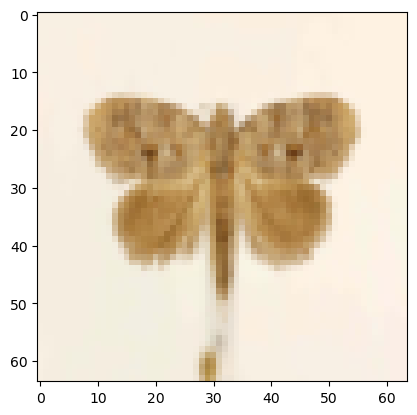

In [106]:
ss  = torch.load("tensor_dataset/all_images.pt")
ss[1000].std()
plt.imshow(torchvision.transforms.functional.to_pil_image(0.5*(ss[100]+1)))

In [107]:
(ss[0]+1)

tensor([[[1.1373, 1.2000, 1.2471,  ..., 1.7333, 1.7098, 1.6627],
         [1.2235, 1.2627, 1.3255,  ..., 1.8039, 1.7804, 1.7490],
         [1.3098, 1.3412, 1.3961,  ..., 1.8745, 1.8667, 1.8275],
         ...,
         [0.8784, 0.8784, 0.8941,  ..., 1.7333, 1.7176, 1.6863],
         [0.8392, 0.8706, 0.8941,  ..., 1.6706, 1.6471, 1.6078],
         [0.8078, 0.8392, 0.8549,  ..., 1.6000, 1.5686, 1.5451]],

        [[1.1765, 1.2314, 1.2863,  ..., 1.7333, 1.6941, 1.6627],
         [1.2627, 1.3020, 1.3569,  ..., 1.8196, 1.7882, 1.7490],
         [1.3412, 1.3725, 1.4118,  ..., 1.8902, 1.8745, 1.8431],
         ...,
         [0.9569, 0.9569, 0.9725,  ..., 1.7490, 1.7255, 1.7098],
         [0.9098, 0.9333, 0.9569,  ..., 1.6941, 1.6471, 1.6157],
         [0.8549, 0.8863, 0.9176,  ..., 1.6157, 1.5686, 1.5294]],

        [[1.0980, 1.1608, 1.2078,  ..., 1.7569, 1.7176, 1.6627],
         [1.1843, 1.2235, 1.2784,  ..., 1.8353, 1.8196, 1.7569],
         [1.2706, 1.3098, 1.3412,  ..., 1.9294, 1.9137, 1.